In [1]:
# import packages

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [3]:
# Change directory to current 

In [4]:
os.chdir('C:/Users/saurabh/Desktop/Project for github')

In [5]:
#Read the file using pandas

In [6]:
df = pd.read_csv("advertising_train.csv")

In [7]:
# explore the dataframe in following 5 cells

In [8]:
df.columns

Index(['case_id', 'companyId', 'countryId', 'deviceType', 'day', 'dow',
       'price1', 'price2', 'price3', 'ad_area', 'ad_ratio', 'requests',
       'impression', 'cpc', 'ctr', 'viewability', 'ratio1', 'ratio2', 'ratio3',
       'ratio4', 'ratio5', 'y'],
      dtype='object')

In [9]:
df.head()

,case_id,companyId,countryId,deviceType,day,dow,price1,price2,price3,ad_area,...,impression,cpc,ctr,viewability,ratio1,ratio2,ratio3,ratio4,ratio5,y
0,1,95,234,1,1,Saturday,0.11,0.30,0.6000,7.5000,...,4350,0.6291,0.0011,0.0557,0.8630,0.4811,0.0646,0.3097,0.6257,0.250111
1,2,43,57,2,1,Saturday,0.00,0.00,0.0000,24.2500,...,1023,0.1887,0.0039,0.4495,1.0000,0.6109,1.0000,0.0000,0.0000,0.816571
2,3,43,57,2,1,Saturday,0.78,1.10,2.1786,24.2500,...,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.035484
3,4,43,57,2,1,Saturday,0.78,1.10,2.1786,24.2500,...,1038,0.5028,0.0019,0.1883,0.6474,0.9595,1.0000,0.0000,0.0000,0.351807
4,5,43,29,2,1,Saturday,4.56,4.56,4.5626,0.0001,...,27,0.0093,0.4444,0.8750,1.0000,1.0000,1.0000,0.0000,0.0000,0.067901


In [10]:
df.isnull().sum()

case_id        0
companyId      0
countryId      0
deviceType     0
day            0
dow            0
price1         0
price2         0
price3         0
ad_area        0
ad_ratio       0
requests       0
impression     0
cpc            0
ctr            0
viewability    0
ratio1         0
ratio2         0
ratio3         0
ratio4         0
ratio5         0
y              0
dtype: int64

In [11]:
df.describe()

,case_id,companyId,countryId,deviceType,day,price1,price2,price3,ad_area,ad_ratio,...,impression,cpc,ctr,viewability,ratio1,ratio2,ratio3,ratio4,ratio5,y
count,214128.000000,214128.000000,214128.000000,214128.000000,214128.000000,214128.000000,214128.000000,214128.000000,214128.000000,214128.000000,...,2.141280e+05,214128.000000,214128.000000,214128.000000,214128.000000,214128.000000,214128.000000,214128.000000,214128.000000,214128.000000
mean,107064.500000,73.332988,119.496180,1.875612,15.790522,0.438229,0.630178,0.932436,4.724445,0.923402,...,5.585714e+03,0.177862,0.032921,0.377929,0.558284,0.491079,0.311646,0.131008,0.188300,0.847004
std,61813.573558,47.817556,76.129206,0.787796,8.385557,1.281403,1.481552,1.839991,6.273410,0.482055,...,9.871334e+04,0.707260,0.092502,0.365938,0.446955,0.414312,0.444088,0.239758,0.297121,1.390593
min,1.000000,40.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000100,0.083330,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000098
25%,53532.750000,43.000000,56.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000100,0.833330,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150415
50%,107064.500000,43.000000,102.000000,2.000000,16.000000,0.010000,0.090000,0.294800,0.000100,1.000000,...,9.900000e+01,0.015700,0.001700,0.331500,0.750000,0.627100,0.027600,0.000000,0.000000,0.419000
75%,160596.250000,95.000000,197.000000,2.000000,23.000000,0.190000,0.570000,0.985650,7.500000,1.000000,...,1.058000e+03,0.125200,0.012000,0.715900,1.000000,0.895700,1.000000,0.163600,0.384700,0.959048
max,214128.000000,159.000000,251.000000,5.000000,30.000000,14.690000,63.120000,78.900000,36.000000,5.000000,...,6.100324e+06,132.533900,2.000000,7.000000,1.000000,1.027000,1.500000,1.076900,1.200000,47.060000


In [12]:
df.dtypes

case_id          int64
companyId        int64
countryId        int64
deviceType       int64
day              int64
dow             object
price1         float64
price2         float64
price3         float64
ad_area        float64
ad_ratio       float64
requests         int64
impression       int64
cpc            float64
ctr            float64
viewability    float64
ratio1         float64
ratio2         float64
ratio3         float64
ratio4         float64
ratio5         float64
y              float64
dtype: object

In [13]:
# investigate the datatypes

In [14]:
df["deviceType"] = df["deviceType"].astype('category')
df["day"] = df["day"].astype('category')
df["case_id"] = df["case_id"].astype('category')
df["countryId"] = df["countryId"].astype('category')
df["companyId"] = df["companyId"].astype('category')

In [15]:
# visualize the column "deviceType" to check its distribution

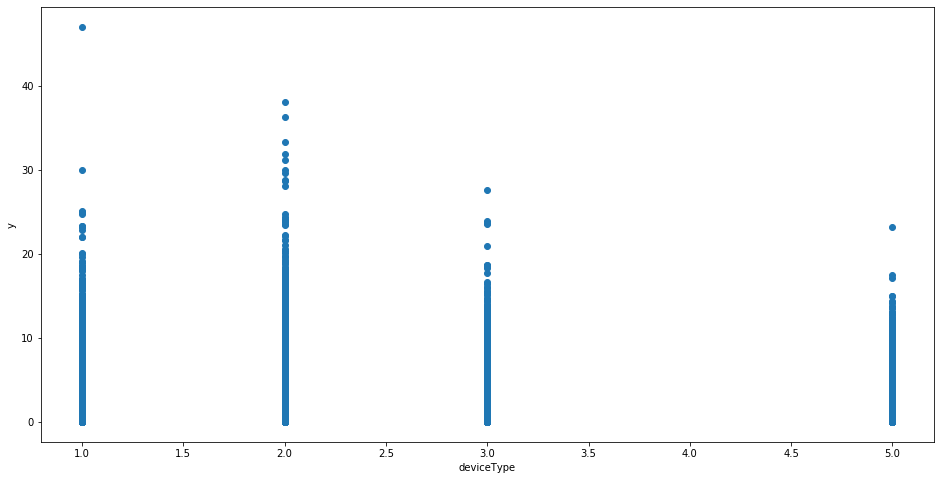

In [16]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['deviceType'], df['y'])
ax.set_xlabel('deviceType')
ax.set_ylabel('y')
plt.show()

In [17]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = df.corr()
corr.sort_values(["y"], ascending = False, inplace = True)
print(corr.y)

Find most important features relative to target
y              1.000000
ctr            0.197221
price3         0.175244
price2         0.159668
viewability    0.158794
price1         0.128919
ratio1         0.072412
ratio3         0.069926
ratio4         0.042551
cpc            0.017002
ratio2         0.012939
impression    -0.024683
ad_ratio      -0.027756
requests      -0.029436
ad_area       -0.049349
ratio5        -0.063455
Name: y, dtype: float64


In [18]:
# As the column impression and request have low corelation with the target varible,
# we may check the corelation again if we combine both the variables

In [19]:
df['IR_Ratio'] = df['impression']/df['requests']

In [20]:
# drop the undired columns

In [21]:
df= df.drop([ 'case_id','companyId','countryId','day', 'dow', 'impression', 'requests', 'ad_area', 'ad_ratio', 'ratio5'], axis =1)

In [22]:
# remove the ouliers by keeping 1.5 standard deviation from the mean

In [23]:
def reject_outliers(data):
    u = np.mean(data)
    s = np.std(data)
    f1 = u - 1.5*s
    f2 = u + 1.5*s
    filtered = np.where(data.between(f1,f2),data, data.median())
    return filtered

df['ctr'] = reject_outliers(df['ctr'])
df['price1'] = reject_outliers(df['price1'])
df['price2'] = reject_outliers(df['price2'])
df['price3'] = reject_outliers(df['price3'] )
df['viewability'] = reject_outliers(df['viewability'] )
df['ratio1'] = reject_outliers(df['ratio1'])
df['ratio2'] = reject_outliers(df['ratio2'])
df['ratio3'] = reject_outliers(df['ratio3'])
df['ratio4'] = reject_outliers(df['ratio4'])
df['y'] = reject_outliers(df['y'])
df['cpc'] = reject_outliers(df['cpc'])
df['IR_Ratio'] = reject_outliers(df['IR_Ratio'])

In [24]:
# divide variab;es into feature and lable

In [25]:
features=df[['deviceType', 'price1', 'price2', 'price3','cpc', 'ctr', 'viewability', 'ratio1', 'ratio2', 'ratio3', 'ratio4','IR_Ratio']].values
label=df[['y']].values

In [26]:
# scale the variables

In [27]:
scaler = preprocessing.StandardScaler()
features_scaled = scaler.fit_transform(features)
label_scaled = scaler.fit_transform(label)

In [28]:
#spliting the training and testing data, keeping 90% for testing and rest for training. I have futher splitted the train 
# data into validation and training data.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features_scaled, label_scaled, test_size = 0.05, random_state = 42)

In [29]:
# Custom class for random forest importance, which shows lowest RMSE

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

# custom function for RFI feature selection inside a pipeline
# here we use n_estimators=100
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    # class constructor 
    # make sure class attributes end with a "_"
    # per scikit-learn convention to avoid errors
    def __init__(self, n_features_=100):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestRegressor
        from numpy import argsort
        model_rfi = RandomForestRegressor(n_estimators=10)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

In [ ]:
# Random forest model, which calculates root mean squared error and mean absolute error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


rf_regressor = RandomForestRegressor(random_state=999)

pipe_RF = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('rf', rf_regressor)])

depths = np.arange(1, 10)



params_pipe_RF = {'rfi_fs__n_features_': [15],                  
                  'rf__max_depth': depths,
                   'rf__min_samples_split': [2,3,4,5,6]}
 


gs_pipe_RF  = GridSearchCV(estimator=pipe_RF, 
                           param_grid=params_pipe_RF, 
                           cv=5,
                           n_jobs=-1,
                           scoring= 'neg_mean_squared_error', 
                           verbose=1)

gs_pipe_RF.fit(x_train, y_train);

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
# check the best parameters of the model and the score

In [ ]:
gs_pipe_RF.best_params_

In [ ]:
gs_pipe_RF.best_score_

In [ ]:
# cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
cv_results_dt = np.sqrt(-cross_val_score(gs_pipe_RF, feature_scaled, target, scoring='neg_mean_squared_error'))
print("RMSE: %0.2f (+/- %0.2f)" % (cv_results_rf.mean(), cv_results_rf.std() * 2))

In [ ]:
# since the dataset was divided in two parts i.e. train and test set, the following section 
# uses the same model on test set

In [ ]:
df_deploy = pd.read_csv("advertising_test.csv", na_values=['?'])

In [ ]:
# check the data type

In [ ]:
df_deploy["deviceType"] = df_deploy["deviceType"].astype('category')
df_deploy["day"] = df_deploy["day"].astype('category')
df_deploy["countryId"] = df_deploy["countryId"].astype('category')
df_deploy["companyId"] = df_deploy["companyId"].astype('category')

In [ ]:
# create a new feature 

In [ ]:
df_deploy['IR_Ratio'] = df_deploy['impression']/df_deploy['requests']

In [ ]:
# remove outliers

In [ ]:
df_deploy['ctr'] = reject_outliers(df_deploy['ctr'] )
df_deploy['price1'] = reject_outliers(df_deploy['price1'])
df_deploy['price2'] = reject_outliers(df_deploy['price2'])
df_deploy['price3'] = reject_outliers(df_deploy['price3'])
df_deploy['viewability'] = reject_outliers(df_deploy['viewability'])
df_deploy['ratio1'] = reject_outliers(df_deploy['ratio1'])
df_deploy['ratio2'] = reject_outliers(df_deploy['ratio2'])
df_deploy['ratio3'] = reject_outliers(df_deploy['ratio3'])
df_deploy['ratio4'] = reject_outliers(df_deploy['ratio4'])
df_deploy['cpc'] = reject_outliers(df_deploy['cpc'])
df_deploy['IR_Ratio'] = reject_outliers(df_deploy['IR_Ratio'])

In [ ]:
# create dataframe for all the required columns

In [ ]:
features_df_deploy=df_deploy[['deviceType', 'price1', 'price2', 'price3','cpc', 'ctr', 'viewability', 'ratio1', 'ratio2', 'ratio3', 'ratio4','IR_Ratio']].values

In [ ]:
# check the shape of the dataframe

In [ ]:
features_df_deploy.shape

In [ ]:
# scale the features

In [ ]:
scaler = preprocessing.StandardScaler()
features_df_deploy_scaled = scaler.fit_transform(features_df_deploy)

In [ ]:
# In order to visually inspect the pridicted value for y, I have created a dataframe prediction_df
prediction_df = pd.DataFrame()
prediction = rf_predictor.predict(features_df_deploy_scaled)

In [ ]:
prediction_df['y'] = prediction
case_id = range(1, 1+len(prediction_df))
prediction_df.insert(0, "case_id", case_id, True) 
prediction_df.head(10)

In [ ]:
prediction_df.to_csv("prediction_google_ad.csv")